In [37]:
import torch
from model import CNN
import numpy as np
from fmnist_dataset import load_fashion_mnist
from torch.utils.data import DataLoader
import torch.nn as nn
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load('../model/ep_37_devacc_92.99_.pt'))

_, __, test = load_fashion_mnist("../data", random=random)
test_loader = DataLoader(test, batch_size=64, shuffle=True)


In [38]:
len(test)

10000

In [39]:
len(test[0])

2

In [40]:
test[0][0].shape

torch.Size([1, 28, 28])

In [41]:
test[0][1]

tensor(9)

In [42]:
target_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

In [43]:
def create_one_hot_targets(labels, target_mapping):
    target_labels = [target_mapping[label.item()] for label in labels]
    one_hot_targets = torch.eye(10)[target_labels]
    return one_hot_targets.to(labels.device)

In [44]:
def whitebox_attack(model, data_loader, target_mapping, device, lr=0.3, max_iter=100):
    adversarial_examples = []
    model.eval()
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 创建目标类别的 one-hot 编码
        target_labels = create_one_hot_targets(labels, target_mapping)
        
        # 初始扰动，只初始化一次
        perturbed_images = images.clone().detach().requires_grad_(True)

        adversarial_index = []
        
        for _ in range(max_iter):
            outputs = model(perturbed_images)
            model.zero_grad()
            
            # 计算 cross-entropy loss
            loss = torch.nn.functional.cross_entropy(outputs, target_labels)
            loss.backward()
            
            # 使用梯度下降进行扰动
            perturbed_images = perturbed_images - lr * perturbed_images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 255).detach().requires_grad_(True)
            
        
            # 检查是否正确扰动
            final_outputs = model(perturbed_images)
            final_preds = final_outputs.argmax(dim=1, keepdim=True)
            mask = final_preds.squeeze(1) == target_labels.argmax(dim=1)
            #print(final_preds.squeeze(1))
            #print(target_labels.argmax(dim=1))
        
            for i in range(len(images)):
                if mask[i] and i not in adversarial_index:
                    adversarial_examples.append((images[i].cpu().numpy(), perturbed_images[i].detach().cpu().numpy(), labels[i].item(), final_preds[i].item()))
                    adversarial_index.append(i)

            #perturbed_images.grad.zero_()

        print("Generated {} adversarial examples.".format(len(adversarial_examples)))
    return adversarial_examples


In [45]:
correct_classfied_images = []
correct_classfied_labels = []

model.eval()

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        initial_outputs = model(images)
        initial_preds = initial_outputs.argmax(dim=1, keepdim=True).squeeze(1)
    
    correct_indices = initial_preds == labels
    for i in range(len(images)):
        if correct_indices[i]:
            correct_classfied_images.append(images[i].cpu().numpy())
            correct_classfied_labels.append(labels[i].item())

In [46]:
print(len(correct_classfied_images))

import random

random.seed(0)

select_indices = random.sample(range(len(correct_classfied_images)), 1000)
select_correct_classified_images = [correct_classfied_images[i] for i in select_indices]
select_correct_classified_labels = [correct_classfied_labels[i] for i in select_indices]

9240


In [47]:
select_correct_classified_images_tensor = torch.tensor(select_correct_classified_images, dtype=torch.float32)
select_correct_classified_labels_tensor = torch.tensor(select_correct_classified_labels, dtype=torch.long)


from torch.utils.data import Dataset, DataLoader

class WhiteboxAttackDataset(Dataset):
    def __init__(self, images, labels):
        super(WhiteboxAttackDataset, self).__init__()
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label


select_correct_classified_dataset = WhiteboxAttackDataset(select_correct_classified_images_tensor, select_correct_classified_labels_tensor)
select_correct_classified_loader = DataLoader(select_correct_classified_dataset, batch_size=64, shuffle=True)

In [48]:
len(select_correct_classified_dataset)

1000

In [49]:
# 进行 white-box attack
adversarial_samples = whitebox_attack(model, select_correct_classified_loader, target_mapping, device)

# 输出结果
print(f"Generated {len(adversarial_samples)} adversarial examples.")
print(f"Success white-box attack rate: {len(adversarial_samples) / len(select_correct_classified_images) * 100:.2f}%")
for ori_img, per_img, orig_label, adv_label in adversarial_samples[:10]:
    print(f"Original label: {orig_label}, Adversarial label: {adv_label}")

Generated 58 adversarial examples.
Generated 115 adversarial examples.
Generated 175 adversarial examples.
Generated 234 adversarial examples.
Generated 293 adversarial examples.
Generated 352 adversarial examples.
Generated 411 adversarial examples.
Generated 472 adversarial examples.
Generated 530 adversarial examples.
Generated 587 adversarial examples.
Generated 647 adversarial examples.
Generated 705 adversarial examples.
Generated 763 adversarial examples.
Generated 822 adversarial examples.
Generated 880 adversarial examples.
Generated 915 adversarial examples.
Generated 915 adversarial examples.
Success white-box attack rate: 91.50%
Original label: 3, Adversarial label: 4
Original label: 3, Adversarial label: 4
Original label: 3, Adversarial label: 4
Original label: 2, Adversarial label: 3
Original label: 0, Adversarial label: 1
Original label: 8, Adversarial label: 9
Original label: 3, Adversarial label: 4
Original label: 0, Adversarial label: 1
Original label: 6, Adversarial 

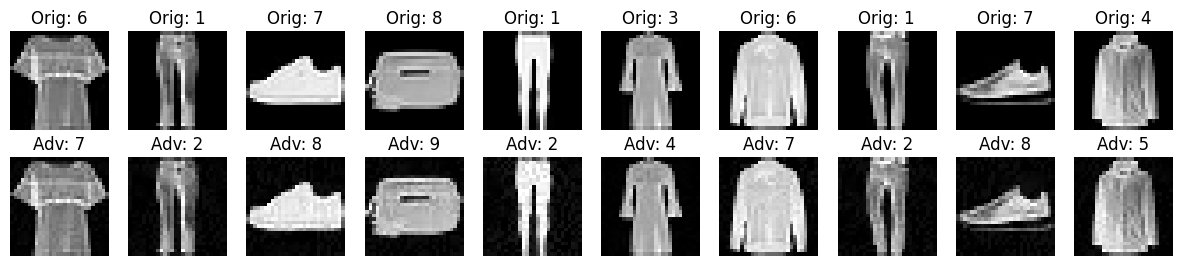

In [50]:
selected_samples = random.sample(adversarial_samples, 10)

import matplotlib.pyplot as plt

# 显示图像和分类结果
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i, (original_img, perturbed_img, orig_label, adv_label) in enumerate(selected_samples):


    # 展示原始图像
    axs[0, i].imshow(original_img.reshape(28, 28), cmap='gray') 
    axs[0, i].title.set_text(f"Orig: {orig_label}")
    axs[0, i].axis('off')

    # 展示对抗样本图像
    axs[1, i].imshow(perturbed_img.reshape(28, 28), cmap='gray') 
    axs[1, i].title.set_text(f"Adv: {adv_label}")
    axs[1, i].axis('off')

plt.show()

In [52]:
# 对模型进行黑盒攻击

import nbimporter

from black_box_attack import mcmc_blackbox_attack

blackbox_adversarial_samples = mcmc_blackbox_attack(model, select_correct_classified_loader, target_mapping, device,\
                                                    sigma = 40, delta_max=900, max_iter=1000)

print("Number of black box adversarial samples:", len(blackbox_adversarial_samples))
print(f"Success black-box attack rate: {len(blackbox_adversarial_samples) / len(select_correct_classified_images) * 100:.2f}%")

Current adversarial samples count: 15
Current adversarial samples count: 31
Current adversarial samples count: 49
Current adversarial samples count: 68
Current adversarial samples count: 87
Current adversarial samples count: 101
Current adversarial samples count: 118
Current adversarial samples count: 135
Current adversarial samples count: 154
Current adversarial samples count: 166
Current adversarial samples count: 180
Current adversarial samples count: 194
Current adversarial samples count: 208
Current adversarial samples count: 229
Current adversarial samples count: 250
Current adversarial samples count: 258
Number of black box adversarial samples: 258
Success black-box attack rate: 25.80%


In [ ]:
import random

for ori_img, adv_img, orig_label, adv_label in random.sample(blackbox_adversarial_samples, 10):
    print(f"Original label: {orig_label}, Adversarial label: {adv_label}")

Original label: 5, Adversarial label: 6
Original label: 7, Adversarial label: 8
Original label: 5, Adversarial label: 6
Original label: 5, Adversarial label: 6
Original label: 5, Adversarial label: 6
Original label: 5, Adversarial label: 6
Original label: 5, Adversarial label: 6
Original label: 7, Adversarial label: 8
Original label: 7, Adversarial label: 8
Original label: 3, Adversarial label: 4


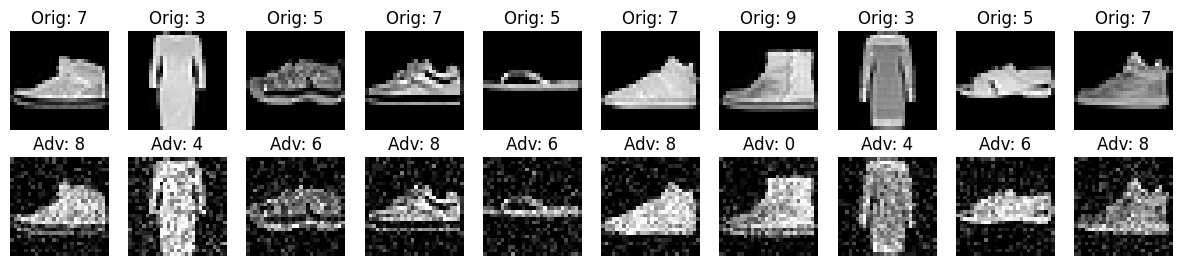

In [77]:
blackbox_selected_samples = random.sample(blackbox_adversarial_samples, 10)

import matplotlib.pyplot as plt

# 显示图像和分类结果
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i, (ori_img, adv_img, ori_label, adv_label) in enumerate(blackbox_selected_samples):
    # 展示原始图像
    axs[0, i].imshow(ori_img.cpu().reshape(28,28), cmap='gray') 
    axs[0, i].title.set_text(f"Orig: {ori_label}")
    axs[0, i].axis('off')

    # 展示对抗样本图像
    axs[1, i].imshow(adv_img.cpu().reshape(28, 28), cmap='gray') 
    axs[1, i].title.set_text(f"Adv: {adv_label}")
    axs[1, i].axis('off')

plt.show()